# MNIST Classification with Iterative Uncertainty

In this notebook, we will implement a simple neural network to classify handwritten digits from the MNIST dataset using PyTorch. On top of it, we will apply the iterative uncertainty approach and evaluate its uncertainty quality in terms of out-of-distribution detection.

In [1]:
import torch
import torchvision
import numpy as np
import random

n_epochs = 3 # number of epochs for training
batch_size_train = 64 # batch size for training
batch_size_test = 1000 # batch size for testing
learning_rate = 0.01 # learning rate for Adam
momentum = 0.5 # optimizer momentum
log_interval = 10 # logging interval for metrics
device = "cuda"

# fixing random seeds
random_seed = 6
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# Train / Test data loading

The MNIST dataset is a collection of handwritten digits commonly used for training and testing in the field of machine learning. It contains 70,000 grayscale images of handwritten digits, split into 60,000 training images and 10,000 test images. Each image is 28x28 pixels in size and represents a digit from 0 to 9.

In [2]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./MNIST/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./MNIST/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

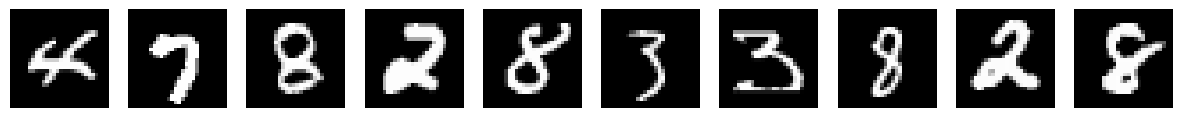

In [3]:
import matplotlib.pyplot as plt

images, targets = next(iter(train_loader))

# Number of images you want to display
num_images = 10

# Create a figure and a row of subplots
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

# Plot each image on a separate subplot
for i in range(num_images):
    axes[i].imshow(images[i, 0], cmap='gray')
    axes[i].axis('off')  # Hide axis

plt.show()

## NN Architechture (Iterative schema)

We define a simple neural network model with several Conv2D layers followed by pooling layers and some fully connected layers. The input layer takes 28x28 MNIST images. The hidden layers have (320, 50) and (50, 50) units respectively, and the output layer has 10 units (one for each digit).

The only difference from the common architecture is that the forward function, in addition to taking an input image, can also take the output from the previous step. Therefore, our model can process inputs iteratively.


In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 10)
        self.activation = nn.ELU()

        self.cf = nn.Linear(10, 50)

    def forward(self, x, pred_prob=None):
        x = self.activation(F.max_pool2d(self.conv1(x), 2))
        x = self.activation(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = self.activation(self.fc1(x))

        # iterative part, if "pred_prob"
        # is not None, we use it for inference
        if pred_prob is not None:
            pred_prob = torch.nn.functional.softmax(pred_prob, 1)
            x += self.activation(self.cf(pred_prob))

        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)

# Model Training

In [5]:
network = Net().to(device)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [6]:
# helper function for training inference
def inference_train(x, N = 3):
    preds = []
    pred = None
    for _ in range(N):
        pred = network(x, pred)
        preds.append(pred)
    return torch.cat(preds)

# helper function for testing inference
def inference_test(x, N = 3):
    preds = []
    pred = None
    for _ in range(N):
        pred = torch.nn.functional.softmax(network(x, pred), 1)
        preds.append(pred)

    # similar to ensembles, final predictions
    # is an average of predictions
    return sum(preds) / N

In [7]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):

    data = data.to(device)
    target = target.to(device)

    optimizer.zero_grad()
    output = inference_train(data)

    # For further details, see Eq. 4 in https://arxiv.org/pdf/2403.16732
    # The first input with an additional "blank" channel, the first term in Eq. 1
    loss = F.nll_loss(output, target.tile(3))

    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)
      output = inference_test(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [8]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-3

for _ in range(2):
  train(epoch)
  test()

<ipython-input-4-5dd87ecea378>:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: -0.1003, Accuracy: 1781/10000 (18%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312376
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.144794
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.467108
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.602299
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.497253
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.241655
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.283207
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.301319
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.293853
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.265691
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.175180
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.286978
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.053208
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.179960
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.142399
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.080546
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.230218
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.307157
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.316138
Train Epoch: 1 [1216

# Out-of-distribution Detection (FashionMNIST)

The FashionMNIST dataset serves as an out-of-distribution (OOD) dataset for the MNIST dataset, providing a more challenging and diverse set of images. While MNIST consists of 70,000 grayscale images of handwritten digits (0-9), FashionMNIST contains 70,000 grayscale images of various clothing items, including t-shirts, trousers, pullovers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots. Both datasets have the same structure, with 28x28 pixel images and 10 classes, making FashionMNIST a suitable alternative for evaluating models trained on MNIST. By using FashionMNIST as OOD data, we can assess the robustness our model when exposed to visually different, yet structurally similar, data.

In [9]:
train_fashion_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('./FMNIST/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_fashion_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('./FMNIST/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

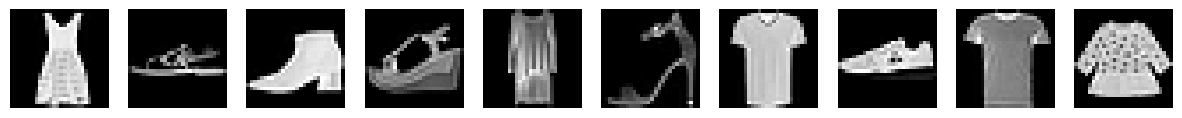

In [10]:
import matplotlib.pyplot as plt

images, targets = next(iter(test_fashion_loader))

# Number of images you want to display
num_images = 10

# Create a figure and a row of subplots
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

# Plot each image on a separate subplot
for i in range(num_images):
    axes[i].imshow(images[i, 0], cmap='gray')
    axes[i].axis('off')  # Hide axis

plt.show()

In [11]:
# Computing OOD metrics

network.eval()

uncertainties = np.array([])
labels = np.array([])
eps = 1e-10

with torch.no_grad():
  for data, target in test_loader:

    data = data.to(device)
    prob = inference_test(data)
    uncertainty = (-prob * torch.log(prob + eps)).sum(dim=1).cpu().detach().numpy()
    label = np.zeros_like(uncertainty)

    uncertainties = np.concatenate([uncertainties, uncertainty])
    labels = np.concatenate([labels, label])

with torch.no_grad():
  for data, target in test_fashion_loader:

    data = data.to(device)

    prob = inference_test(data)
    uncertainty = (-prob * torch.log(prob + eps)).sum(dim=1).cpu().detach().numpy()
    label = np.ones_like(uncertainty)

    uncertainties = np.concatenate([uncertainties, uncertainty])
    labels = np.concatenate([labels, label])

<ipython-input-4-5dd87ecea378>:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [12]:
import sklearn.metrics
roc_auc = sklearn.metrics.roc_auc_score(labels, uncertainties)
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(labels, uncertainties)
pr_auc = sklearn.metrics.auc(recall, precision)

# evaluate ROC- and PR-AUC metrics, see https://arxiv.org/abs/1802.10501 for more details
print(f"ROC AUC: {roc_auc:.4f} ")
print(f"PR AUC: {pr_auc:.4f}")

ROC AUC: 0.9536 
PR AUC: 0.9517


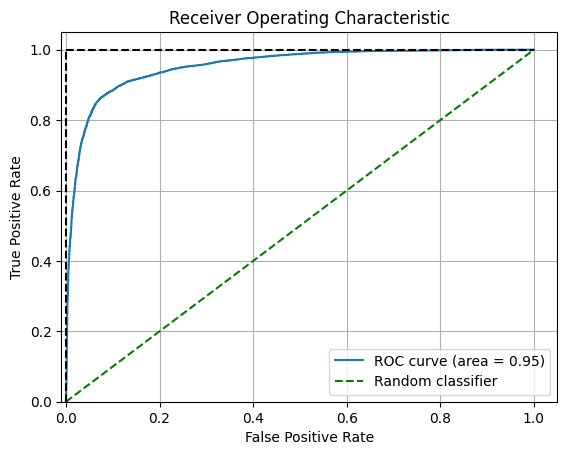

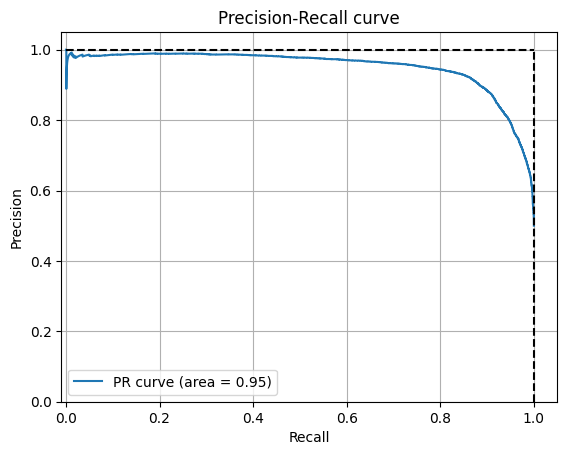

In [13]:
# Plot ROC curve
fpr, tpr, _ = sklearn.metrics.roc_curve(labels, uncertainties)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'g--', label="Random classifier")
plt.hlines(1, xmin=0, xmax=1, color='k', linestyle="--")
plt.vlines(0, ymin=0, ymax=1, color='k', linestyle="--")
plt.xlim([-0.01, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.grid()
plt.legend(loc="lower right")
plt.show()

# Plot PR curve
plt.figure()
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.hlines(1, xmin=0, xmax=1, color='k', linestyle="--")
plt.vlines(1, ymin=0, ymax=1, color='k', linestyle="--")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.xlim([-0.01, 1.05])
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend(loc="lower left")
plt.show()
